# <span style="color:red">  Esercitazione_07</span>

In [15]:
#Librerie necessarie

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import expon         #per fit esponenziale autocorrelazione
from scipy.optimize import curve_fit
import scipy
import time, sys

### Informazioni utili:

- Le cartelle *<font color="blue">Molecular_Dynamics_NVE e MonteCarlo_NVT</font>* contengono tutti i codici scritti per la realizzazione dell'esercitazione.
- Nella cartella *<font color="blue">Results</font>* sono già contenuti tutti i risultati di output suddivisi a seconda del sistema considerato e della fase analizzata. Questi ultimi sono quelli analizzati ed esposti in questo notebook e non è quindi necessaria la ricompilazione e la riesecuzione dei codici; nel caso si volessero rieffettuare le simulazioni è sufficiente digitare *"<font color="green">make run</font>"* da terminale all'interno di ognuna delle cartelle delle fasi poichè questo permette di cancellare tutti i vecchi risultati già presenti prima di crearne altri (la scrittuta dei file avviene appendendo i nuovi risultati ai files di output e quindi una nuova compilazione ed esecuzione prevede la cancellazione di tutti i risultati precedenti). Per poter effettuare invece tutte le simulazioni automaticamente si esegua *<font color="grey">script.sh</font>* all'interno del sistema desiderato.
- Di seguito sono riportati esclusivamente i risultati dell'esercizio *07.1* e *07.4* poichè i codici per ottenerli comprendono tutti i miglioramenti richiesti nei punti restanti.

## Esercizio 07.1

Sono state effettuate delle simulazioni di un sistema nell'ensamble canonico, utilizzando l'algoritmo di Metropolis per il campionamento del peso di Boltzmann, nelle seguente condizioni termodinamiche:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c^\star = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c^\star = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c^\star = 5.0$)

dove $^\star$ indica le grandezze in unità ridotte.

La prima fase della simulazione prevede una fase di equilibrazione del sistema. Il numero di steps necessari per questa fase è stato scelto osservando i valori istantanei di pressione ed energia potenziale per particella; è stato cosi possibile impostare il valore di questo parametro in modo tale che le fluttuazioni delle grandezze dopo questa fase fossero uniformi. Di seguito sono riportati i grafici rappresentanti l'andamento dei valori istantanei di pressione $P$ ed energia potenziale per particella $U/N$ dopo la fase di equilibrazione in funzione del numero di simulazioni $M$.

In [16]:
#Fase solida
epot_ist_solid = np.loadtxt('Results/MonteCarlo_NVT/Solid/istant.epot.0', usecols=(0),unpack='true')
pres_ist_solid = np.loadtxt('Results/MonteCarlo_NVT/Solid/istant.pres.0', usecols=(0),unpack='true')

#Fase liquida
epot_ist_liquid = np.loadtxt('Results/MonteCarlo_NVT/Liquid/istant.epot.0', usecols=(0),unpack='true')
pres_ist_liquid = np.loadtxt('Results/MonteCarlo_NVT/Liquid/istant.pres.0', usecols=(0),unpack='true')

#Fase gassosa
epot_ist_gas = np.loadtxt('Results/MonteCarlo_NVT/Gas/istant.epot.0', usecols=(0),unpack='true')
pres_ist_gas = np.loadtxt('Results/MonteCarlo_NVT/Gas/istant.pres.0', usecols=(0),unpack='true')

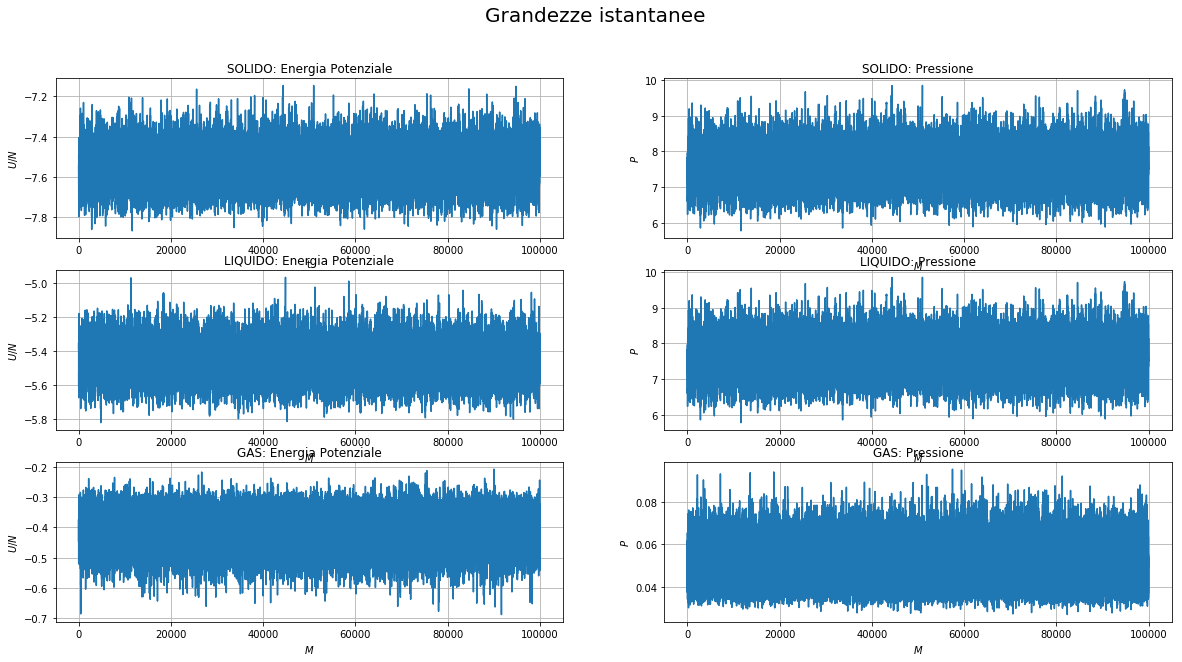

In [17]:
plt.figure(figsize=(20,10))
plt.suptitle('Grandezze istantanee',fontsize=20)

#SOLIDO
#Energia Potenziale
plt.subplot(3,2,1)
plt.plot(epot_ist_solid)
plt.title('SOLIDO: Energia Potenziale')
plt.xlabel('t')
plt.ylabel('$U/N$')
plt.grid(True)
#Pressione 
plt.subplot(3,2,2)
plt.plot(pres_ist_solid)
plt.title('SOLIDO: Pressione')
plt.xlabel('$M$')
plt.ylabel('$P$')
plt.grid(True)

#LIQUIDO
#Energia Potenziale 
plt.subplot(3,2,3)
plt.plot(epot_ist_liquid)
plt.title('LIQUIDO: Energia Potenziale')
plt.xlabel('$M$')
plt.ylabel('$U/N$')
plt.grid(True)
#Pressione 
plt.subplot(3,2,4)
plt.plot(pres_ist_solid)
plt.title('LIQUIDO: Pressione')
plt.xlabel('$M$')
plt.ylabel('$P$')
plt.grid(True)

#GAS
#Energia Potenziale 
plt.subplot(3,2,5)
plt.plot(epot_ist_gas)
plt.title('GAS: Energia Potenziale')
plt.xlabel('$M$')
plt.ylabel('$U/N$')
plt.grid(True)

#Pressione 
plt.subplot(3,2,6)
plt.plot(pres_ist_gas)
plt.title('GAS: Pressione')
plt.xlabel('$M$')
plt.ylabel('$P$')
plt.grid(True)
plt.show()

Inoltre in questa fase è stata impostata l'ampiezza dell'algoritmo di Metroplis in modo tale da avere un probabilità di accettazione $\simeq 50\%$. Di seguito si riporta una tabella con tutti i parametri scelti per ottimizzare le simulazioni.

|Parametro |Fase solida | Fase liquida | Fase gassosa|
|----------|------------|--------------|-------------|
|Passi per l'equilibrazione|$4\times10^3$ |$4\times10^3$|$3\times10^4$|
|Passo del Metropolis      |0.11          |0.205        |         6.0|

Si può notare come il passo per la fase gassosa risulti essere molto maggiore rispetto a quello scelto per le altre fasi; nonostante questa scelta non è stato possibile scendere al di sotto di una probabilità di accettazione $\simeq 60\%$ poichè essendo poco denso il massimo passo che è possibile scegliere è pari alla metà del box considerato ($\simeq 6$) a causa della condizioni periodiche al contorno.

Successivamente attraverso i valori istantanei di pressione ed energia potenziale è stato possibile calcolare la funzione di autocorrelazione (con tempo $MC$ discreto) di queste grandezze al fine di ottenere il tempo MonteCarlo di correlazione $\tau_{c}$ attraverso un fit esponenziale ($e^{-\tau/\tau_c}$) del grafico della funzione di correlazione. L'analisi dei dati ottenuti dalla simulazione è stata svolta interamente in *python*. Di seguito è riportata la formula analitica della funzione di correlazione, la sua implementazione ed applicazione al caso in esame.

$$
Ac(\tau) = \frac{\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')x(t'+\tau)-\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')\times \frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t'+\tau)}{\frac{1}{t}\sum_{t' = 0}^{t}x^2(t')-\left(\frac{1}{t}\sum_{t' = 0}^{t}x(t')\right)^2} \, ,
$$

dove $x(t)$ sarà il valore di $P$ o $U/N$ al tempo $t$.

In [18]:
#Funzione di autocorrelazione                x == dati, t == tau, t_max == t
def Auto_corr(x,t):
    t_max=len(x)
    norm=(1./(t_max-t))
    x_old=x[0:t_max-t]
    x_new=x[t:]
    
    num= norm*np.sum(x_old*x_new)-(norm**2)*np.sum(x_old)*np.sum(x_new)
    den=(1./t_max)*np.sum(x**2)- ((1./t_max)*np.sum(x))**2
    return num/den

In [19]:
n_dati=len(pres_ist_solid)
n_punti=int(n_dati/100)

correlation_pres_solid=np.zeros(n_punti)
correlation_epot_solid=np.zeros(n_punti)
correlation_pres_liquid=np.zeros(n_punti)
correlation_epot_liquid=np.zeros(n_punti)
correlation_pres_gas=np.zeros(n_punti)
correlation_epot_gas=np.zeros(n_punti)

for t in range(n_punti):
    correlation_pres_solid[t]=Auto_corr(pres_ist_solid,t)
    correlation_epot_solid[t]=Auto_corr(epot_ist_solid,t)
    correlation_pres_liquid[t]=Auto_corr(pres_ist_liquid,t)
    correlation_epot_liquid[t]=Auto_corr(epot_ist_liquid,t)
    correlation_pres_gas[t]=Auto_corr(pres_ist_gas,t)
    correlation_epot_gas[t]=Auto_corr(epot_ist_gas,t)

Di seguito sono riportati i grafici delle funzioni di autocorrelazione della pressione e dell'energia potenziale per tutte le fasi considerate (scala bilogaritmica) sui quali è stato eseguito un fit esponenziale.

/Users/riccardoaiolfi/Downloads/intelpython3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


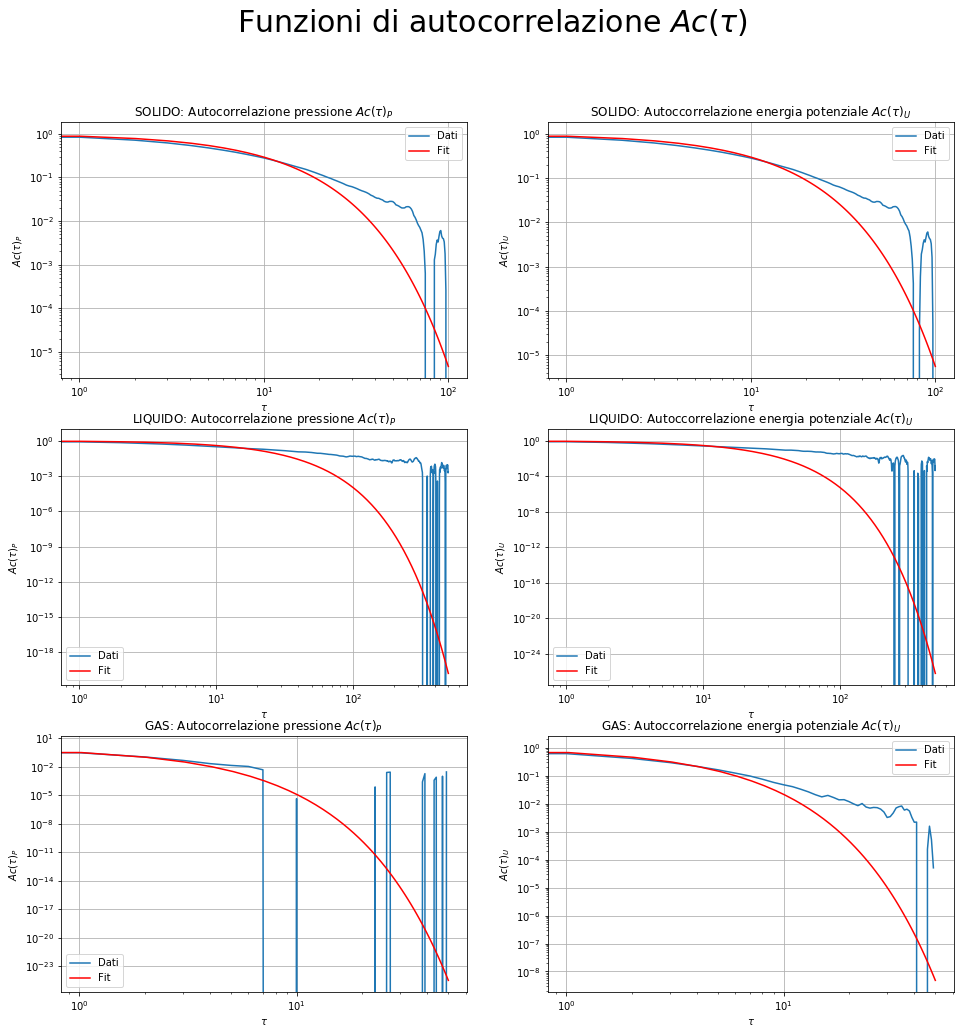

In [20]:
plt.figure(figsize=(16,16))
plt.suptitle(r'Funzioni di autocorrelazione $Ac(\tau)$',fontsize=30)

#SOLIDO
n_cut = 100 #Tagli dei fit
t=np.linspace(0,n_cut, n_cut)
correlation_pres_solid = correlation_pres_solid[0:n_cut]
correlation_epot_solid = correlation_epot_solid[0:n_cut] 
plt.subplot(3,2,1)
f_solid_press = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_pres_solid) 
plt.plot(correlation_pres_solid,label='Dati')
plt.plot(t,np.exp(-t*f_solid_press[0][1]),label='Fit', color = 'red')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_P$')
plt.grid(True)
plt.title(r'SOLIDO: Autocorrelazione pressione $Ac(\tau)_P$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
plt.subplot(3,2,2)
f_solid_en = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_epot_solid) 
plt.plot(correlation_epot_solid,label='Dati')
plt.plot(t,np.exp(-t*f_solid_en[0][1]),label='Fit', color = 'red')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_U$')
plt.grid(True)
plt.title(r'SOLIDO: Autoccorrelazione energia potenziale $Ac(\tau)_U$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')

#LIQUIDO
n_cut = 500 
t=np.linspace(0,n_cut, n_cut)
correlation_pres_liquid = correlation_pres_liquid[0:n_cut]
correlation_epot_liquid = correlation_epot_liquid[0:n_cut] 
plt.subplot(3,2,3)
f_liquid_press = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_pres_liquid) 
plt.plot(correlation_pres_liquid,label='Dati')
plt.plot(t,np.exp(-t*f_liquid_press[0][1]),label='Fit',color = 'red')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_P$')
plt.grid(True)
plt.title(r'LIQUIDO: Autocorrelazione pressione $Ac(\tau)_P$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
plt.subplot(3,2,4)
f_liquid_en = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_epot_liquid) 
plt.plot(correlation_epot_liquid,label='Dati')
plt.plot(t,np.exp(-t*f_liquid_en[0][1]),label='Fit',color = 'red')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_U$')
plt.grid(True)
plt.title(r'LIQUIDO: Autoccorrelazione energia potenziale $Ac(\tau)_U$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')

#GAS
n_cut = 50 
t=np.linspace(0,n_cut, n_cut)
correlation_pres_gas = correlation_pres_gas[0:n_cut]
correlation_epot_gas = correlation_epot_gas[0:n_cut] 
plt.subplot(3,2,5)
f_gas_press = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_pres_gas) 
plt.plot(correlation_pres_gas,label='Dati')
plt.plot(t,np.exp(-t*f_gas_press[0][1]),label='Fit',color = 'red')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_P$')
plt.grid(True)
plt.title(r'GAS: Autocorrelazione pressione $Ac(\tau)_P$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')
plt.subplot(3,2,6)
f_gas_en = scipy.optimize.curve_fit(lambda l,a,b: np.exp(-b*l), t,  correlation_epot_gas)
plt.plot(correlation_epot_gas,label='Dati')
plt.plot(t,np.exp(-t*f_gas_en[0][1]),label='Fit',color = 'red')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Ac(\tau)_U$')
plt.grid(True)
plt.title(r'GAS: Autoccorrelazione energia potenziale $Ac(\tau)_U$')
plt.legend()
plt.xscale('Log')
plt.yscale('Log')

plt.show()

Per poter ottenere i precedenti fit è stato eseguito un cut-off sui dati ottenuti poichè ad elevati valori di $\tau$ la funzione di correlazione presentava dei valori troppo oscillanti per permettere la convergenza del fit. Di seguito si riportano i tempi di autocorrelazione ottenuti.

In [21]:
print('SOLIDO: Tempo di correlazione pressione: ',1./f_solid_press[0][1])
print('SOLIDO: Tempo di correlazione energia potenziale: ',1./f_solid_en[0][1])
print()
print('LIQUIDO: Tempo di correlazione pressione: ',1./f_liquid_press[0][1])
print('LIQUIDO: Tempo di correlazione energia potenziale: ',1./f_liquid_en[0][1])
print()
print('GAS: Tempo di correlazione pressione: ',1./f_gas_press[0][1])
print('GAS: Tempo di correlazione energia potenziale: ',1./f_gas_en[0][1])

SOLIDO: Tempo di correlazione pressione:  8.13535993614788
SOLIDO: Tempo di correlazione energia potenziale:  8.258012679491165

LIQUIDO: Tempo di correlazione pressione:  10.965743296461923
LIQUIDO: Tempo di correlazione energia potenziale:  8.284366721127828

GAS: Tempo di correlazione pressione:  0.8864214771552946
GAS: Tempo di correlazione energia potenziale:  2.6106137465963775


Si può notare che solo per il solido i tempi di correlazione per pressione ed energia potenziale sono simili. Avendo ricavato i tempi di correlazione è possibile ottenere un'informazione sulla grandezza dei blocchi istanziati nel motodo del *data blocking* poichè per poter avere delle misurazioni indipendenti è necessario prendere una larghezza pari ad almeno $2 \tau_{c}.$

Inoltre è possibile effettuare una stima dell'errore dei valori di aspettazione di $U/N$ e $P$ a partire da quelli istantanei, attraverso il metodo del *data blocking*, in funzione della dimensione dei blocchi $L = M/N$, con $N$ numero di blocchi, con $L \in [10,10^3]$. Si riporta di seguito l'implementazione del *data blocking*, la sua applicazione ai dati ottenuti per tutte le fasi considerate e i grafici conclusivi.

In [22]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def blocking(r,L): # r == numero di dati, L == dimesione del blocco 
    
    M = len(r)
    N=int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
        
    return err_prog[len(err_prog)-1]

In [31]:
%%time #Tempo di esecuzione della cella
L = np.arange(10,5000,10)   
LL = len(L)
err_pres_solid = np.zeros(LL)
err_epot_solid = np.zeros(LL)
err_pres_liquid = np.zeros(LL)
err_epot_liquid = np.zeros(LL)
err_pres_gas = np.zeros(LL)
err_epot_gas = np.zeros(LL)
s=0
for i in L:
    err_pres_solid[s]=blocking(pres_ist_solid,i)
    err_epot_solid[s]=blocking(epot_ist_solid,i)
    err_pres_liquid[s]=blocking(pres_ist_liquid,i)
    err_epot_liquid[s]=blocking(epot_ist_liquid,i)
    err_pres_gas[s]=blocking(pres_ist_gas,i)
    err_epot_gas[s]=blocking(epot_ist_gas,i)
   
    s+=1

CPU times: user 6min 41s, sys: 505 ms, total: 6min 41s
Wall time: 6min 42s


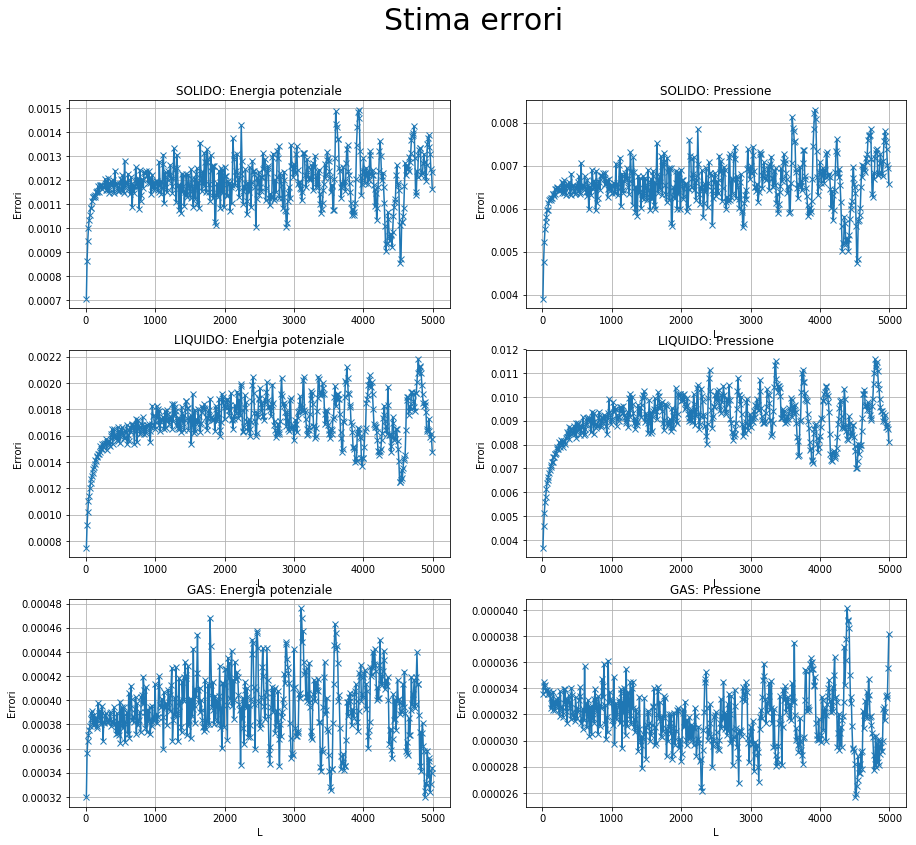

In [32]:
plt.figure(figsize=(15,13))
plt.suptitle('Stima errori',fontsize=30)

plt.subplot(3,2,1)
plt.plot(L,err_epot_solid, marker='x')
plt.title('SOLIDO: Energia potenziale')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(L,err_pres_solid, marker='x')
plt.title('SOLIDO: Pressione')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(L,err_epot_liquid, marker='x')
plt.title('LIQUIDO: Energia potenziale')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(L,err_pres_liquid, marker='x')
plt.title('LIQUIDO: Pressione')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(L,err_epot_gas, marker='x')
plt.title('GAS: Energia potenziale')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(L,err_pres_gas, marker='x')
plt.title('GAS: Pressione')
plt.xlabel('L')
plt.ylabel('Errori')
plt.grid(True)

plt.show()

Si può notare che per il solido e il liquido gli errori tendono ad aumentare al crescere dalla dimensione del blocco fino a quando a tendo a convergere ad un certo valore presentando delle forti oscillazioni. Questo comportamento è imputabile al fatto che per valori piccoli di $L$, cioè con $L < 2 \tau_{c}$ i dati all'interno del singolo blocco sono correlati tra loro e di conseguenza gli errori sono piccoli. Aumendando sempre di più la dimensione del blocco si raggiunge il **vero** errore statistico fino a quando $L > 2 \tau_{c}$, limite oltre il quale l'aumento delle dimensione non incide ulteriormente sulla stima dell'errore.
Per il gas invece la condizione di saturazione è raggiunta costruendo blocchi con un numero piccolo di dati poichè presenta un tempo di correlazione basso e molto inferiore a quelli del solido e del liquido.

## Esercizio 07.4

Nel codice *<font color="gray">Monte_Carlo_NVT.cpp</font>* è stato introdotto l'algoritmo per il calcolo della funzione di distribuzione radiale $g(r)$ dove $r$ è la distanza radiale tra le particelle del sistema. Per effettuare un confronto tra i codice sviluppati per studiare un ensamble microcanonico e quello canonico, il medesimo algoritmo è stato introdotto nel codice *<font color="gray">Mol_Dyn_NVE.cpp</font>* utilizzato in *<font color="blue">Esercitazione_04</font>*.

Di seguito sono riportati i grafici dei valori medi con i corrisponenti errori di $P$, $U/N$, $T$ (in unità del $SI$) in funzione del numero di blocchi $N_{blocks}$ per la fase solida, liquida e gassosa per Argon e Krypton nelle condizione termodinamiche riporatate all'inizio del jupyter. Inoltre sono anche riportati gli istogrammi delle $g(r)$ in funzione del raggio. Negli stessi grafici sono rappresentati sia i dati ricati dalla simulazione nell'ensamble microcanonico NVE sia quelli ricavati dalla simulazione nell'ensamble canonico NVT.

Si può notare la compatibilità delle distribuzioni radiali $g(r)$ calcolate nei due ensamble differenti. Questo è dovuto al fatto che stiamo utlizzando due ensamble diversi per studiare un sistema nelle stesse identiche condizioni e perciò è corretta questa uguaglianza tra i due risultati. Inoltre i valori ottenuti per la $g(r)$ sono compatibili con le previsioni teoriche poichè nella fase solida presenta ben visibili i picchi di primi e secondi vicini mentre nella fase liquida e gassosa, essendo dei sistemi disordinati, per grandi $r$, la $g(r)$ tende a 1.

Effettuando un confronto con i risultati ottenuti dalla precedente esercitazione (*<font color="blue">Esercitazione_04</font>*) si riscontra una differenza tra i valori; il motivo è riconducibile all'inserimento nel codice delle correzioni di coda per l'energia e la pressione, le quali quindi apportano un contributo non trascurabile.

## Argon

In [23]:
#Conversioni necessarie per ottenere i grafici in unità del Sistema Internazionale

Kb = 1.38E-23             #costante di Boltzmann
sigma = 0.34*(10**(-9))   #Unità di lunghezza in metri
e_Kb = 120.               #e/Kb     
e = (e_Kb*Kb)             #Energia in J
p = e/(sigma**3)          #Pressione in Pa 

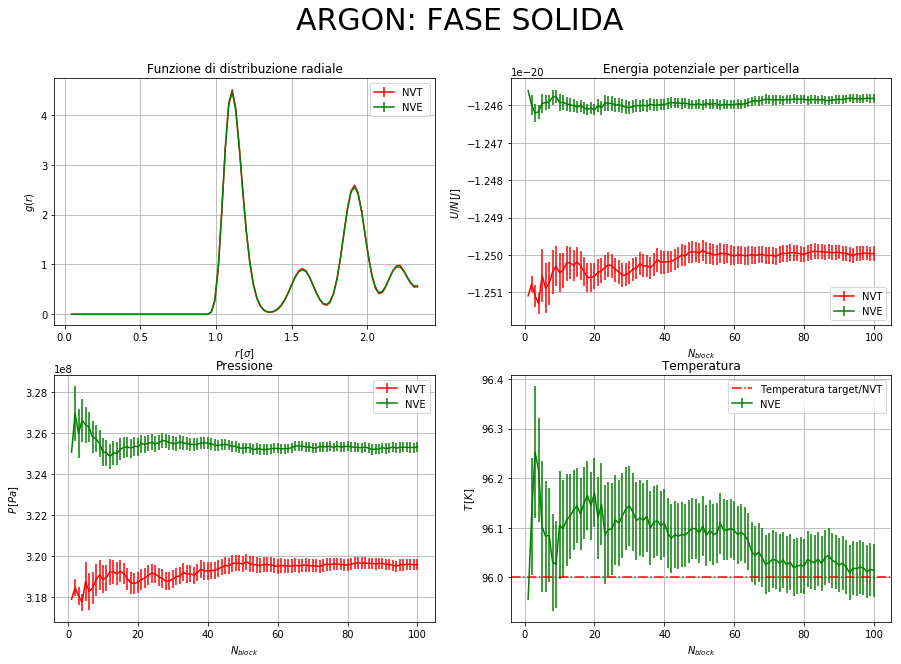

In [24]:
plt.figure(figsize=(15,10))
plt.suptitle('ARGON: FASE SOLIDA',fontsize=30)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Results/MonteCarlo_NVT/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE', color = 'green')
plt.ylabel('$g(r)$')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Results/MonteCarlo_NVT/Solid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/ave_epot.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE', color = 'green')
plt.ylabel('$U/N \, [J]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Energia potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Results/MonteCarlo_NVT/Solid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p, color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/ave_pres.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE', color = 'green')
plt.ylabel('$P \, [Pa]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/ave_temp.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE', color = 'green')
plt.axhline(y=0.8*e_Kb, color = 'red',linestyle='-.',label = 'Temperatura target/NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

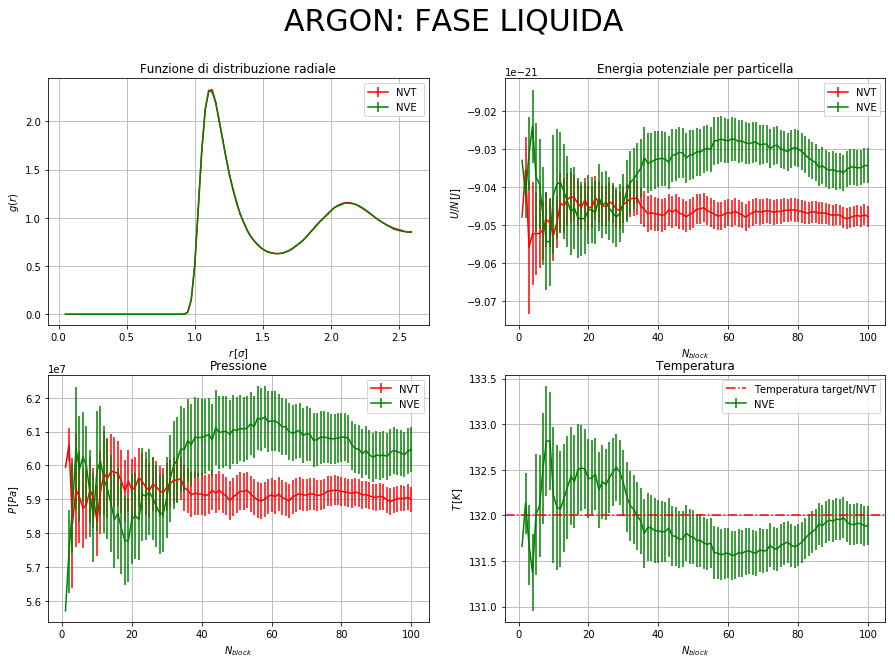

In [25]:
plt.figure(figsize=(15,10))
plt.suptitle('ARGON: FASE LIQUIDA',fontsize=30)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Results/MonteCarlo_NVT/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,color = 'red', label = 'NVT ')
r, gr, err_gr = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE', color = 'green')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.xlabel('$r \, [\sigma]$')
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Results/MonteCarlo_NVT/Liquid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/ave_epot.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE', color = 'green')
plt.ylabel('$U/N \, [J]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Energia potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Results/MonteCarlo_NVT/Liquid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/ave_pres.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE', color = 'green')
plt.ylabel('$P \, [Pa]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/ave_temp.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE', color = 'green')
plt.axhline(y=1.1*e_Kb,color = 'red', linestyle='-.',label = 'Temperatura target/NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

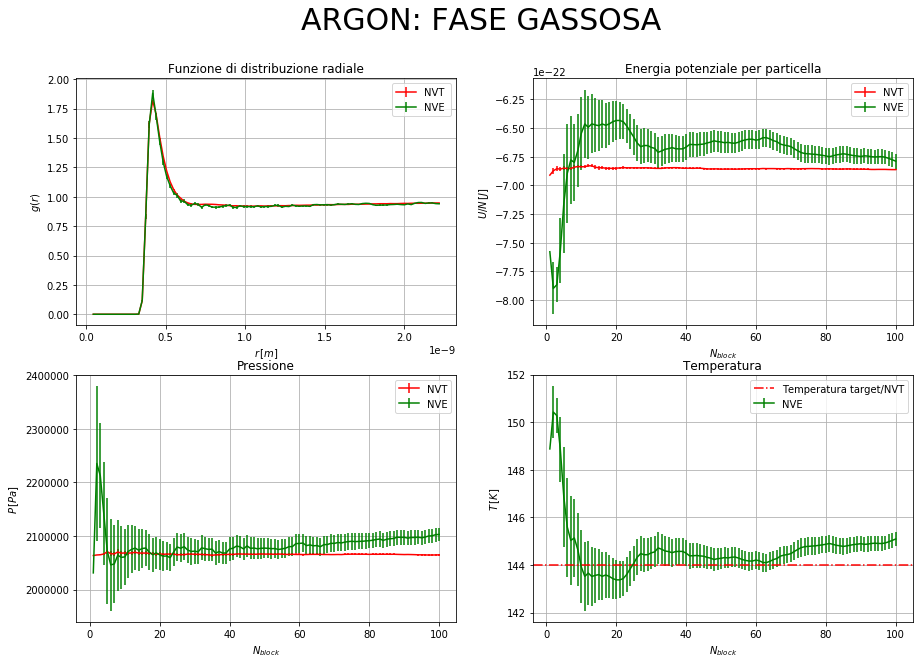

In [26]:
plt.figure(figsize=(15,10))
plt.suptitle('ARGON: FASE GASSOSA',fontsize=30)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Results/MonteCarlo_NVT/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r*sigma,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r*sigma,gr, err_gr,label = 'NVE', color = 'green')
plt.ylabel('$g(r) $')
plt.xlabel('$r \, [m]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Results/MonteCarlo_NVT/Gas/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/ave_epot.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE', color = 'green')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Results/MonteCarlo_NVT/Gas/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/ave_pres.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE', color = 'green')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/ave_temp.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE', color = 'green')
plt.axhline(y=1.2*e_Kb, linestyle='-.',color = 'red',label = 'Temperatura target/NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

## Kripton

In [27]:
#Conversioni necessarie per ottenere i grafici in unità del Sistema Internazionale

Kb = 1.38E-23              #Costante di Boltzmann
sigma = 0.364*(10**(-9))   #Unità di lunghezza in metri
e_Kb = 164.                #e/Kb
e = (e_Kb*Kb)              #Energia in J
p = e/(sigma**3)           #Pressione in Pa 

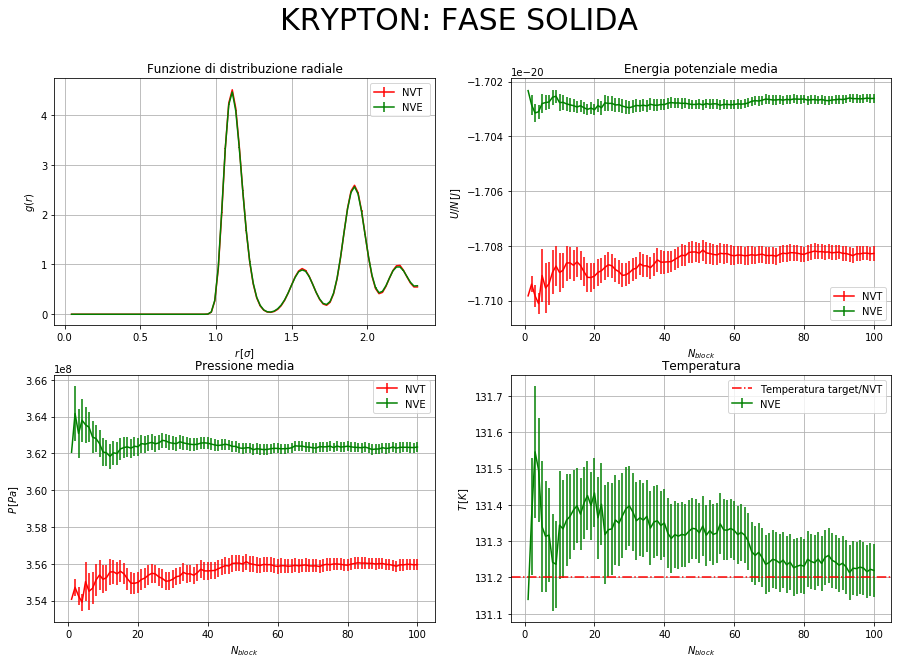

In [28]:
plt.figure(figsize=(15,10))
plt.suptitle('KRYPTON: FASE SOLIDA',fontsize=30)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Results/MonteCarlo_NVT/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE', color = 'green')
plt.ylabel('$g(r)$')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Results/MonteCarlo_NVT/Solid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/ave_epot.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE', color = 'green')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia potenziale media')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Results/MonteCarlo_NVT/Solid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/ave_pres.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE', color = 'green')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione media')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Results/Molecular_Dynamics_NVE/Solid/ave_temp.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE', color = 'green')
plt.axhline(y=0.8*e_Kb, linestyle='-.',color = 'red',label = 'Temperatura target/NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

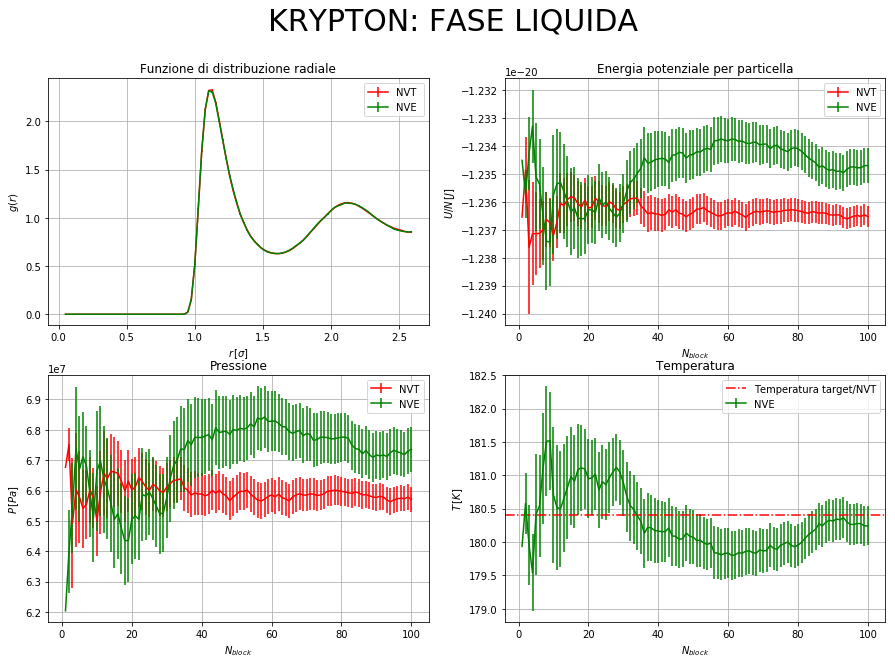

In [29]:
plt.figure(figsize=(15,10))
plt.suptitle('KRYPTON: FASE LIQUIDA',fontsize=30)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Results/MonteCarlo_NVT/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,color = 'red', label = 'NVT ')
r, gr, err_gr = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE', color = 'green')
plt.ylabel('$g(r)$')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Results/MonteCarlo_NVT/Liquid/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/ave_epot.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE', color = 'green')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Results/MonteCarlo_NVT/Liquid/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/ave_pres.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE', color = 'green')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Results/Molecular_Dynamics_NVE/Liquid/ave_temp.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE', color = 'green')
plt.axhline(y=1.1*e_Kb, linestyle='-.',color = 'red',label = 'Temperatura target/NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()

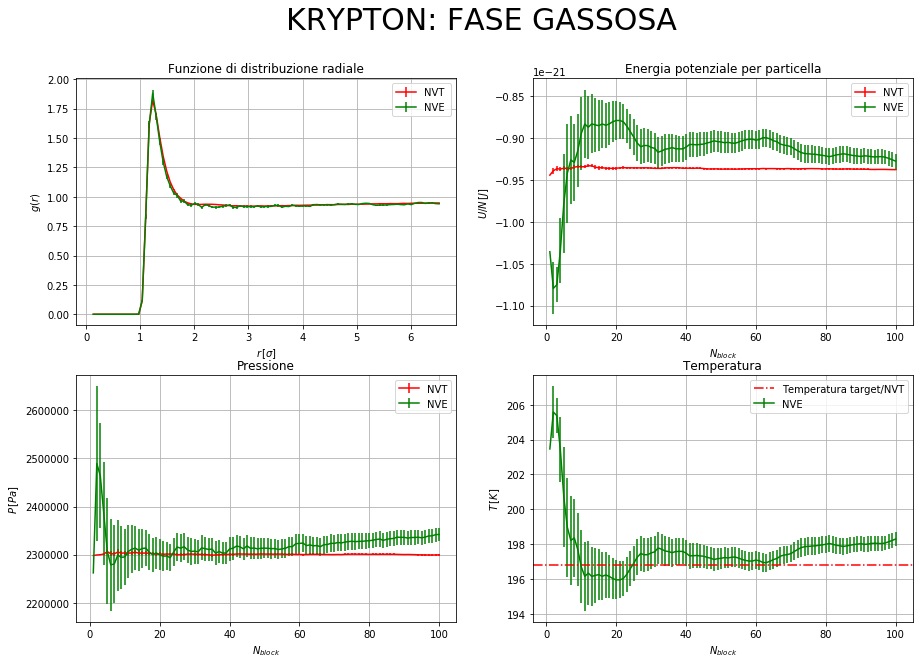

In [30]:
plt.figure(figsize=(15,10))
plt.suptitle('KRYPTON: FASE GASSOSA',fontsize=30)

plt.subplot(2,2,1)
r, gr, err_gr = np.loadtxt('Results/MonteCarlo_NVT/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr, color = 'red',label = 'NVT ')
r, gr, err_gr = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/output.gave.0', usecols=(0,1,2),unpack='true')
plt.errorbar(r,gr, err_gr,label = 'NVE', color = 'green')
plt.ylabel('$g(r) $')
plt.xlabel('$r \, [\sigma]$')
plt.grid(True)
plt.title('Funzione di distribuzione radiale')
plt.legend()

plt.subplot(2,2,2)
N, epot, err_epot = np.loadtxt('Results/MonteCarlo_NVT/Gas/output.epot.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,color = 'red',label = 'NVT')
N, epot, err_epot = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/ave_epot.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,epot*e, err_epot*e,label = 'NVE', color = 'green')
plt.ylabel('$U/N \, [J]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Energia potenziale per particella')
plt.legend()

plt.subplot(2,2,3)
N, pres, err_pres = np.loadtxt('Results/MonteCarlo_NVT/Gas/output.pres.0', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,color = 'red',label = 'NVT')
N, pres, err_pres = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/ave_pres.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,pres*p, err_pres*p,label = 'NVE', color = 'green')
plt.ylabel('$P \, [Pa]$')
plt.xlabel('$N_{block}$')
plt.grid(True)
plt.title('Pressione')
plt.legend()

plt.subplot(2,2,4)
N, temp, err_temp = np.loadtxt('Results/Molecular_Dynamics_NVE/Gas/ave_temp.out', usecols=(0,1,2),unpack='true')
plt.errorbar(N,temp*e_Kb, err_temp*e_Kb,label = 'NVE', color = 'green')
plt.axhline(y=1.2*e_Kb, linestyle='-.',color = 'red',label = 'Temperatura target/NVT')
plt.ylabel('$T \, [K]$')
plt.grid(True)
plt.xlabel('$N_{block}$')
plt.title('Temperatura')
plt.legend()

plt.show()